In [15]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Dropout,BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

In [51]:
def contrastiveLoss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))
def accuracy(y_true, y_pred): 
    ones = K.ones_like(y_pred) 
    return K.mean(K.equal(y_true, ones - K.clip(K.round(y_pred), 0, 1)), axis=-1) 

In [53]:
def weightInit(shape,dtype=None):
    return rng.normal(loc = 0.0, scale = 1e-2, size = shape)
def biasInit(shape,dtype=None):
    return rng.normal(loc = 0.5, scale = 1e-2, size = shape)
input_shape = (200, 200, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

model = Sequential()
model.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,kernel_initializer=weightInit,kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128,(7,7),activation='relu',kernel_regularizer=l2(2e-4),kernel_initializer=weightInit,bias_initializer=biasInit))
model.add(MaxPooling2D())
model.add(Conv2D(128,(4,4),activation='relu',kernel_regularizer=l2(2e-4),kernel_initializer=weightInit,bias_initializer=biasInit))
model.add(MaxPooling2D())
model.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=weightInit,kernel_regularizer=l2(2e-4),bias_initializer=biasInit))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
model.add(Flatten())
# model.add(Dropout(0.5))
model.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=weightInit,bias_initializer=biasInit))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = model(left_input)
encoded_r = model(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=biasInit)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
optimizer = Adam(0.001)
siamese_net.compile(loss=contrastiveLoss,optimizer='RMSprop', metrics=[accuracy])

In [54]:
siamese_net.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 4096)         304237376   input_29[0][0]                   
                                                                 input_30[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 4096)         0           sequential_14[0][0]  

In [55]:
%run DatasetPrepare.ipynb

In [56]:
createLabelsTargets = CreateLabelsTargets("train_HB.csv")
createLabelsTargets.load_csv_and_treat() 
(X_train, X_test, y_train, y_test) = createLabelsTargets.create_labels_and_targets()

In [57]:
imagesPath= os.getcwd()+'/modelHB_200/'
# Creating training data generator
dataTrainLoader = DataLoader(imagesPath,X_train, y_train)


In [46]:
#Training loop
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every= 10 # interval for printing loss (iterations)
checkOverfitting = 20
batch_size = 32
epochs = 9000
N_way = 5 # how many classes for testing one-shot tasks
n_val = 250 #number of one-shot tasks to validate on
lossHistory = []
val_accHistory = []
print("training")
for i in range(1, epochs):
    (inputs,targets)=dataTrainLoader.getBatch(batch_size)
    (loss)=siamese_net.train_on_batch(inputs,targets)
    lossHistory.append(loss)
    if i % checkOverfitting == 0:
        print("Comparing results with x_train and x_test to check overfitting")
        val_acc_test = dataTrainLoader.test_oneshot(siamese_net,N_way,n_val,X_test,y_test,verbose=True)
        val_acc_train = dataTrainLoader.test_oneshot(siamese_net,N_way,n_val,X_train,y_train,verbose=True)
        print("Accuracy in train {:.2f}, accuracy in test {:.2f} ".format(val_acc_train,val_acc_test))
    elif i % evaluate_every == 0:
        val_acc = dataTrainLoader.test_oneshot(siamese_net,N_way,n_val,X_test,y_test,verbose=True)
        val_accHistory.append(val_acc)
    if i % loss_every == 0:
        print("iteration {}, loss: {:.2f}, val_acc: {:.2f}".format(i,loss,val_acc))

training
Evaluating model on 250 random 5 way one-shot learning tasks ...
Got an average of 26.4% 5 way one-shot learning accuracy
iteration 10, loss: 4.77, val_acc: 26.40
Comparing results with x_train and x_test to check overfitting
Evaluating model on 250 random 5 way one-shot learning tasks ...
Got an average of 23.6% 5 way one-shot learning accuracy
Evaluating model on 250 random 5 way one-shot learning tasks ...
Got an average of 21.6% 5 way one-shot learning accuracy
Accuracy in train 21.60, accuracy in test 23.60 
iteration 20, loss: 4.48, val_acc: 26.40
Evaluating model on 250 random 5 way one-shot learning tasks ...
Got an average of 25.2% 5 way one-shot learning accuracy
iteration 30, loss: 3.53, val_acc: 25.20
Comparing results with x_train and x_test to check overfitting
Evaluating model on 250 random 5 way one-shot learning tasks ...
Got an average of 16.4% 5 way one-shot learning accuracy
Evaluating model on 250 random 5 way one-shot learning tasks ...
Got an average of 

KeyboardInterrupt: 

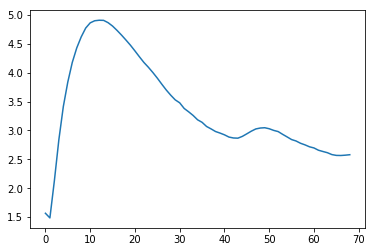

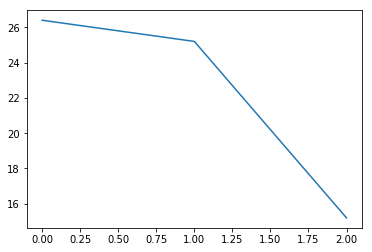

In [47]:
plt.plot(lossHistory)
plt.show()
plt.plot(val_accHistory)
plt.show()